In [1]:
# ===============================================
# 1. Importación de librerías
# ===============================================

!pip install scikit-learn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split


In [2]:
# ===============================================
# 2. Montar drive
# ===============================================

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ===============================================
# 3. Carga del dataset
# ===============================================

#file_path = '/content/drive/MyDrive/Usuarios-Caracteristicas por usuario.xlsx'
file_path = '/content/drive/MyDrive/MachineLearning/TRAIN/GPT/grouped_trainytrial.xlsx'
#file_path = '/content/drive/MyDrive/MachineLearning/TRAIN/GPT/grouped_trainytrial.xlsx'

# Cargar el archivo Excel en un DataFrame
df = pd.read_excel(file_path)

Seleccion de caracteristicas

In [16]:
# ===============================================
# 4. Selección de características
# ===============================================

# Codificar la columna 'sentiment' en valores numéricos
label_encoder_sentiment = LabelEncoder()
df['sentiment_numeric'] = label_encoder_sentiment.fit_transform(df['sentiment'])

# Características específicas
columnas_seleccionadas = [
    'toxicity',

    'POS','NEU','NEG',

    'alegria', 'tristeza' ,'miedo','disgusto','enojo', 'sorpresa',

    'yo', 'me', 'mi', 'mí',

    'num_palabras_largas',
    #'num_signos_puntuacion'
    #'num_palabras_mayusculas',
    #'num_palabras_primera_mayuscula',
    'negaciones',

    #'hora'

    #'Medicamento_ansiedad','Medicamento_depresion',

    'falta de motivacion',
    'aislamiento social',
    'pensamientos suicidas',
   # 'baja autoestima',

    #'insomnio',
    'pensamientos acelerados',
    #'ataques de panico',

]

# Normalizar solo las columnas numéricas específicas
scaler = MinMaxScaler()
cols_to_normalize = [
    'num_palabras_largas','negaciones','num_palabras_mayusculas',
    'num_palabras_primera_mayuscula', 'num_signos_puntuacion',

]

# Verificar que las columnas a normalizar existan en el DataFrame antes de normalizar
cols_to_normalize = [col for col in cols_to_normalize if col in df.columns]
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

# Seleccionar las características
X = df[columnas_seleccionadas].copy()

# Codificar las etiquetas de la columna 'label'
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])  # 0, 1 y 2 deben estar en esta columna


# ===============================================
# 4. División del dataset 70% train / 30% test
# ===============================================

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




**Inicializar y entrenar el modelo de Gradient Boosting**

F1-Score : 0.8219
Accuracy: 0.8219
Precision : 0.8219
Recall : 0.8219


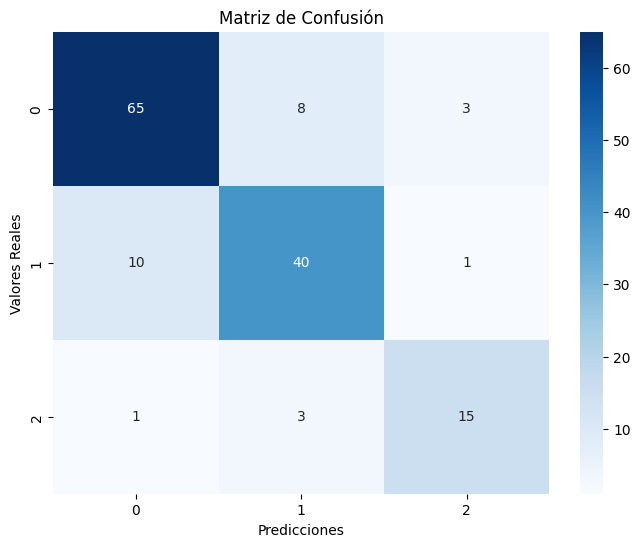


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        76
           1       0.78      0.78      0.78        51
           2       0.79      0.79      0.79        19

    accuracy                           0.82       146
   macro avg       0.81      0.81      0.81       146
weighted avg       0.82      0.82      0.82       146



In [17]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported for np.sqrt

# ===============================================
# 5. Configuración base del modelo GBM
# ===============================================

gb_model = GradientBoostingClassifier(
    #base
    loss='log_loss',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    subsample=1.0,
    max_features=None,
    min_samples_split=2,
    random_state=42

)

# ===============================================
# 6. Entrenamiento con hiperparámetros base
# ===============================================

gb_model.fit(X_train, y_train)

# Predicciones
y_pred = gb_model.predict(X_test)

# ===============================================
# 7. Evaluación del modelo base
# ===============================================

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')



# ROC-AUC solo si es binario
if len(set(y_test)) == 2:
    y_prob = gb_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"ROC-AUC: {roc_auc:.4f}")

# Imprimir métricas
print(f"F1-Score : {f1 :.4f}")
print(f"Accuracy: {accuracy :.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall :.4f}")


# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

**Importancia de las caracteristicas**

**Ajuste de hiperparametros**

In [ ]:
# ===============================================
# 8. Búsqueda de hiperparámetros (GridSearchCV)
# ===============================================

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Modelo base con configuración inicial
gb_model = GradientBoostingClassifier(loss='log_loss', random_state=42)

# Espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 150, 200],           # Número de árboles (boosting rounds)
    'learning_rate': [0.05, 0.1, 0.2],         # Tasa de aprendizaje
    'max_depth': [3, 5],                       # Profundidad máxima del árbol
    'subsample': [0.7, 0.8, 1.0],              # Fracción de datos usados por árbol
    'max_features': ['sqrt', 'log2', None],    # Subconjunto de variables por split
    'min_samples_split': [2, 5, 10]            # Mínimas muestras para dividir un nodo
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='f1_weighted',                     # Métrica de evaluación principal (como en LGBM)
    cv=5,                                      # Validación cruzada (5 pliegues)
    verbose=2,                                 # Nivel de detalle del proceso
    n_jobs=-1                                  # Usar todos los núcleos disponibles
)

# Ejecutar búsqueda
grid_search.fit(X_train, y_train)

# Resultados de la mejor combinación encontrada
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print(f"Mejor F1 Score promedio (validación cruzada): {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 486 candidates, totalling 2430 fits


KeyboardInterrupt: 

**Validacion cruzada**

In [ ]:
# ===============================================
# 9. Validación Cruzada
# ===============================================

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Asignar el mejor estimador de GridSearch
optimized_gb_model = grid_search.best_estimator_

# Entrenar el modelo optimizado con los mejores hiperparámetros
optimized_gb_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = optimized_gb_model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Ponderado para problemas multiclase
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Reporte de clasificación
class_report = classification_report(y_test, y_pred)

# Mostrar resultados
print(f"Accuracy (weighted): {accuracy :.4f}%")
print(f"Precision (weighted): {precision :.4f}%")
print(f"Recall (weighted): {recall :.4f}%")
print(f"F1 Score (weighted): {f1 :.4f}%")
print("\nMatriz de Confusión:")
print(conf_matrix)
print("\nReporte de Clasificación:")
print(class_report)


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

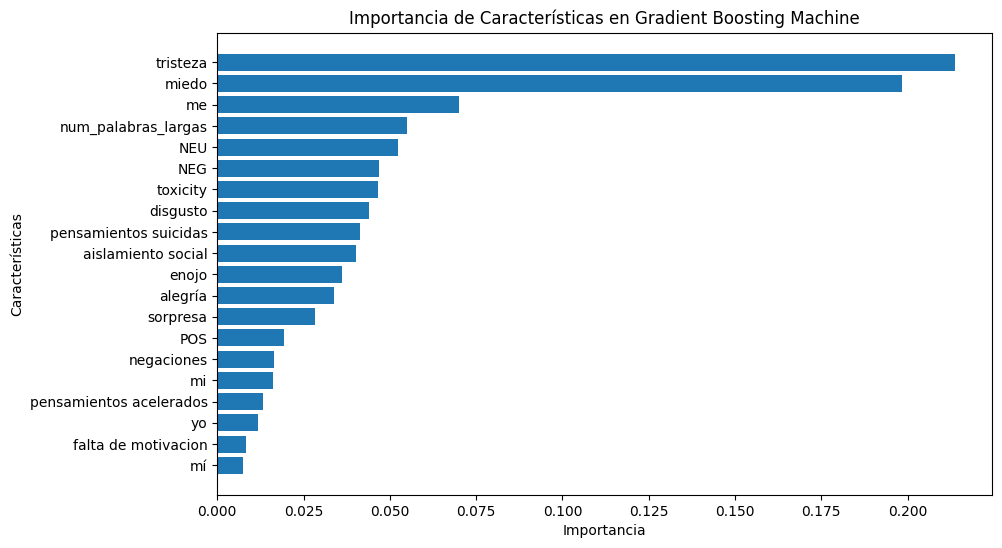

In [ ]:
# ===============================================
# 10. Importancia de características acumulada
# ===============================================

import matplotlib.pyplot as plt
import numpy as np  # Importa numpy para trabajar con arrays

# Importancia de características
importances = optimized_gb_model.feature_importances_

# Obtén los índices de las características ordenadas por importancia
indices_ordenados = np.argsort(importances)[::1]  # [::-1] invierte el orden para descendente

# Ordena las características y sus importancias
caracteristicas_ordenadas = X_train.columns[indices_ordenados]
importancias_ordenadas = importances[indices_ordenados]

# Visualizar con las características ordenadas
plt.figure(figsize=(10, 6))
plt.barh(caracteristicas_ordenadas, importancias_ordenadas)
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Importancia de Características en Gradient Boosting Machine")
plt.show()